In [1532]:
import scipy.integrate as integrate
import numpy as np
import numpy.linalg as la
from numpy import cross
from numpy.random import rand
import matplotlib.pyplot as plt
import csv
import scipy as sc
import time

from linear_dynamics_LVLH import propagator_absolute,M_to_LVLH,integrate_matrix,matrix_dynamics,propagator_relative,get_phi

In [1533]:
r12 = 384400 # km, distance between primary attractors
mu = 1.215e-2 # no unit, mass parameter of the system
TU = 1/(2.661699e-6) # s, inverse of the relative angular frequency between the two primary attractors
L1x = 0.83691513 # nd, position of the L1 point along the x direction
L2x = 1.15568217 # nd, position of the L2 point along the x direction

In [1534]:
file = open("initial_conditions.csv","r")
reader = csv.reader(file)
data = []
for lines in reader:
    if lines != []:
        data.append(lines)
file.close()

data = np.asarray(data)
period = data[0,-1]
period = period.astype('float64')
# print(period.dtype)
initial_conditions_target_M = np.asarray(data[0,:6])
initial_conditions_target_M = initial_conditions_target_M.astype('float64')
initial_conditions_chaser_LVLH = np.asarray(data[0,6:12])
initial_conditions_chaser_LVLH = initial_conditions_chaser_LVLH.astype('float64')
initial_conditions_chaser_M = np.asarray(data[1,6:12])
initial_conditions_chaser_M = initial_conditions_chaser_M.astype('float64')
initial_conditions_target_bary = np.asarray(data[2,:6])
initial_conditions_target_bary = initial_conditions_target_bary.astype('float64')
initial_conditions_chaser_bary = np.asarray(data[2,6:12])
initial_conditions_chaser_bary = initial_conditions_chaser_bary.astype('float64')
initial_conditions_murakami_M = np.asarray(data[3,:12])
initial_conditions_murakami_M = initial_conditions_murakami_M.astype('float64')
initial_conditions_murakami_LVLH = np.asarray(data[4,:12])
initial_conditions_murakami_LVLH = initial_conditions_murakami_LVLH.astype('float64')
# print(initial_conditions_target_M.dtype)

In [1535]:
# # Initial conditions, current conditions are for a L2 Southern NRHO

# R = np.matrix([[-1, 0, 0],[0, -1, 0],[0, 0, 1]]) # rotation matrix to go from the bary to the Moon frame and conversely (+ translation along x)

# # Initial position w.r.t. the barycenter of the Earth-Moon system in the bary frame
# x0_bary = 1.0269694420519750E+0 # nd 1.1340389525913128E+0, southern L1 NHRO 9.2280005557282274E-1
# y0_bary = -1.0620425026230252E-26 # nd -1.9603275922757012E-28, southern L1 NHRO1.6386233489716853E-28
# z0_bary = -1.8530606468865049E-1 # nd -3.1177930540447237E-33, southern L1 NHRO -2.1575768509057866E-1

# # nitial position w.r.t. the barycenter of the Earth-Moon system in the Moon frame
# initial_position_M = R@np.matrix([x0_bary-(1-mu), y0_bary, z0_bary]).reshape((3,1))
# x0_M = initial_position_M[0,0]
# y0_M = initial_position_M[1,0]
# z0_M = initial_position_M[2,0]

# # Initial velocity w.r.t. the barycenter of the Earth-Moon system in the bary frame
# vx0_bary = 1.8339007690300910E-14 # nd 5.3802690301291542E-15, southern L1 NHRO 4.4327633188679963E-13
# vy0_bary = 	-1.1378551488655682E-1 # nd 1.1050885595242482E-1, southern L1 NHRO 1.2826547451754347E-1
# vz0_bary = 1.3151545077882733E-13 # nd 4.2488243310471582E-33, southern L1 NHRO 2.4299327620081873E-12

# # Initial velocity w.r.t. the barycenter of the Earth-Moon system in the Moon frame
# initial_velocity_M = R@np.matrix([vx0_bary, vy0_bary, vz0_bary]).reshape((3,1))
# vx0_M = initial_velocity_M[0,0]
# vy0_M = initial_velocity_M[1,0]
# vz0_M = initial_velocity_M[2,0]
# period = 1.5763752384473892E+0 # nd 3.3898323438578979E+0, southern L1 NHRO 1.8036720655626510E+0

# # Initial conditions in the Moon frame for the target spacecraft
# initial_conditions_M = [x0_M, y0_M, z0_M, vx0_M, vy0_M, vz0_M]

# # Initial conditions in the bary frame for the target spacecraft
# initial_conditions_bary = [x0_bary, y0_bary, z0_bary, vx0_bary, vy0_bary, vz0_bary]

# Simulating for 12 hours like in the article
length = 12*3600/TU # nd for a 12-hour simulation
length2 = 100*60/TU
t_simulation = np.linspace(0,length,1000) # change the duration of the simulations HERE
# t_simulation2 = np.linspace(0,period,1000)

In [1536]:
# # Setting the initial conditions for the chaser. We'll use the same orbit as the precedent one for the target.
# # Initial conditions for the chaser are defined in the LVLH frame

# # Maybe do that in another file and save it in a csv file so that the initial conditions don't change everytime we run the code here
# # So that we can actually compare results with the same initial conditions more easily
# distance_to_target_km = 10 # in km, CHANGE to see to which extent the linear approximation works (try up to 100km in the article)
# distance_to_target = distance_to_target_km/r12 # adimensionalized initial condition

# rho_x0_LVLH = rand()*distance_to_target # NOT ENTIRELY RANDOM SINCE IT CAN'T BE NEGATIVE, CHANGE THAT!!! -> is it relevant?
# rho_y0_LVLH = rand()*np.sqrt(distance_to_target**2 - rho_x0_LVLH**2)
# rho_z0_LVLH = np.sqrt(distance_to_target**2 - rho_x0_LVLH**2 - rho_y0_LVLH**2)

# velocity_rel_target_km = 0 # in km/s, CHANGE to see to which extent the linear approximation works
# velocity_rel_target = velocity_rel_target_km/r12*TU # adimensionalized initial condition

# rho_vx0_LVLH = rand()*velocity_rel_target
# rho_vy0_LVLH = rand()*np.sqrt(velocity_rel_target**2 - rho_vx0_LVLH**2)
# rho_vz0_LVLH = np.sqrt(velocity_rel_target**2 - rho_vx0_LVLH**2 - rho_vy0_LVLH**2)
# # print(rho_vx0_LVLH,rho_vy0_LVLH,rho_vz0_LVLH)

# # Initial conditions to integrate the relative dynamics
# # The initial conditions are in the Moon frame for the target part and in the LVLH frame for the chaser part
# initial_conditions_chaser_LVLH = [x0_M, y0_M, z0_M, vx0_M, vy0_M, vz0_M, rho_x0_LVLH, rho_y0_LVLH, rho_z0_LVLH, rho_vx0_LVLH, rho_vy0_LVLH, 
#                                   rho_vz0_LVLH]

In [1537]:
# Simulating the relative dynamics
# y_orbit = integrate.odeint(propagator_relative,initial_conditions_chaser_LVLH,t_simulation[:],args=(mu,))
y_orbit = integrate.odeint(propagator_relative,np.concatenate((initial_conditions_target_M,initial_conditions_chaser_LVLH)),t_simulation[:],args=(mu,))
# y_orbit = integrate.odeint(propagator_relative,initial_conditions_murakami_LVLH,t_simulation[:],args=(mu,))

In [1538]:
# Computing the initial LVLH frame to get the rotation matrix and get the initial conditions in the Moon synodic frame
# r_M_init = np.asarray([[x0_M],[y0_M],[z0_M]])
# r_dot_M_init = np.asarray([[vx0_M],[vy0_M],[vz0_M]])  

# [A_M_LVLH_init,_,_,_] = M_to_LVLH(r_M_init.reshape(3),r_dot_M_init.reshape(3))
# rho_init_LVLH = np.asarray([[rho_x0_LVLH],[rho_y0_LVLH],[rho_z0_LVLH]]).reshape((3,1))
# rho_init_M = ((A_M_LVLH_init.T)@rho_init_LVLH).reshape(3)
# [rho_x0_M,rho_y0_M,rho_z0_M] = ((A_M_LVLH_init.T)@rho_init_LVLH).reshape(3)

# h_init = cross(initial_conditions_M[:3],initial_conditions_M[3:])
# der_state_init = propagator_absolute(initial_conditions_M,0,mu)
# r_ddot_M_init = der_state_init[3:6]
# omega_lm_LVLH_init = np.zeros(3)
# omega_lm_LVLH_init[1] = - la.norm(h_init)/(la.norm(initial_conditions_M[:3])**2)
# omega_lm_LVLH_init[2] = -la.norm(initial_conditions_M[:3])/(la.norm(h_init)**2) * np.dot(h_init, r_ddot_M_init)

# rho_dot_init_LVLH = np.zeros((3,1))
# rho_dot_init_LVLH[0] = rho_vx0_LVLH
# rho_dot_init_LVLH[1] = rho_vy0_LVLH
# rho_dot_init_LVLH[2] = rho_vz0_LVLH

# rho_dot_init_M = (A_M_LVLH_init.T)@(rho_dot_init_LVLH + cross(omega_lm_LVLH_init.reshape(3),rho_init_LVLH.reshape(3)).reshape((3,1)))
# rho_vx0_M = rho_dot_init_M[0,0]
# rho_vy0_M = rho_dot_init_M[1,0]
# rho_vz0_M = rho_dot_init_M[2,0]

# initial_conditions_chaser_M = [x0_M + rho_x0_M, y0_M + rho_y0_M, z0_M + rho_z0_M, vx0_M + rho_vx0_M, vy0_M + rho_vy0_M, vz0_M + rho_vz0_M]

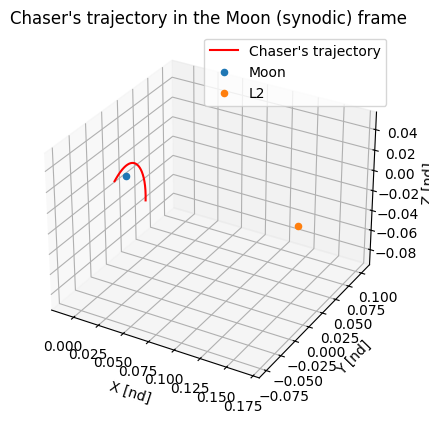

In [1539]:
# Propagating the non-linear dynamics in the Moon (synodic) frame
# chaser_orbit = integrate.odeint(propagator_absolute,initial_conditions_murakami_M[6:],t_simulation,args=(mu,))
chaser_orbit = integrate.odeint(propagator_absolute,initial_conditions_chaser_M,t_simulation,args=(mu,))

# Plotting the orbit of the target
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(-chaser_orbit[:,0], -chaser_orbit[:,1], chaser_orbit[:,2], color='r', label="Chaser's trajectory")
ax.scatter(0, 0, 0, label='Moon')
ax.scatter(L2x-(1-mu), 0, 0, label='L2')
ax.axis('equal')
ax.set_xlabel('X [nd]')
ax.set_ylabel('Y [nd]')
ax.set_zlabel('Z [nd]')
ax.legend()
plt.title("Chaser's trajectory in the Moon (synodic) frame")
plt.grid()
plt.show()

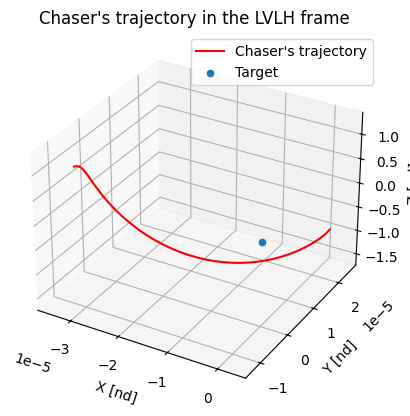

In [1540]:
rho_M_history_true = np.zeros_like(chaser_orbit[:,:3])
rho_dot_M_history_true = np.zeros_like(chaser_orbit[:,:3])
rho_LVLH_history_true = np.zeros_like(chaser_orbit[:,:3])
rho_dot_LVLH_history_true = np.zeros_like(chaser_orbit[:,:3])
for i in range(len(chaser_orbit[:,0])):
    rho_M = chaser_orbit[i,:3] - y_orbit[i,:3]
    rho_dot_M = chaser_orbit[i,3:6] - y_orbit[i,3:6]
    
    rho_M_history_true[i] = rho_M.reshape(3)
    rho_dot_M_history_true[i] = rho_dot_M.reshape(3)
    
    A_M_LVLH,_,_,_ = M_to_LVLH(y_orbit[i,:3],y_orbit[i,3:6])
    rho_LVLH = A_M_LVLH @ (rho_M.reshape((3,1)))
    
    h = np.cross(y_orbit[i,:3].reshape(3),y_orbit[i,3:6].reshape(3))
    der = propagator_absolute(y_orbit[i,:6],0,mu)
    r_ddot = der[3:6]
    omega_lm_LVLH = np.zeros((3,1))
    omega_lm_LVLH[1] = - la.norm(h)/(la.norm(y_orbit[i,:3])**2)
    omega_lm_LVLH[2] = - la.norm(y_orbit[i,:3])/(la.norm(h)**2) * np.dot(h.reshape(3),r_ddot.reshape(3))
    rho_dot_LVLH = A_M_LVLH @ rho_dot_M.reshape((3,1)) - np.cross(omega_lm_LVLH.reshape(3),rho_LVLH.reshape(3)).reshape((3,1))
    
    rho_LVLH_history_true[i] = rho_LVLH.reshape(3)
    rho_dot_LVLH_history_true[i] = rho_dot_LVLH.reshape(3)

# Plotting the orbit of the target
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(rho_LVLH_history_true[:,0], rho_LVLH_history_true[:,1], rho_LVLH_history_true[:,2], color='r', label="Chaser's trajectory")
ax.scatter(0, 0, 0, label='Target')
ax.axis('equal')
ax.set_xlabel('X [nd]')
ax.set_ylabel('Y [nd]')
ax.set_zlabel('Z [nd]')
ax.legend()
plt.title("Chaser's trajectory in the LVLH frame")
plt.grid()
plt.show()

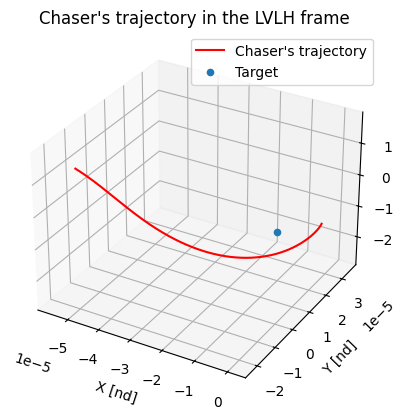

In [1541]:
matrix_dyn = integrate.odeint(integrate_matrix,np.concatenate((initial_conditions_target_M,initial_conditions_chaser_LVLH)),t_simulation,args=(mu,))
# matrix_dyn = integrate.odeint(integrate_matrix,np.concatenate((initial_conditions_target_M,initial_conditions_murakami_LVLH[6:])),t_simulation,args=(mu,))

# Plotting the orbit of the target
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(matrix_dyn[:,6], matrix_dyn[:,7], matrix_dyn[:,8], color='r', label="Chaser's trajectory")
ax.scatter(0, 0, 0, label='Target')
ax.axis('equal')
ax.set_xlabel('X [nd]')
ax.set_ylabel('Y [nd]')
ax.set_zlabel('Z [nd]')
ax.legend()
plt.title("Chaser's trajectory in the LVLH frame")
plt.grid()
plt.show()

In [1542]:
error_mat_lin_dist = np.zeros(y_orbit.shape[0])
error_mat_lin_vel = np.zeros(y_orbit.shape[0])
for i in range(y_orbit.shape[0]):
    error = la.norm(matrix_dyn[i,6:9]-rho_LVLH_history_true[i,:3])
    error_mat_lin_dist[i] = error
    error_vel = la.norm(matrix_dyn[i,9:12]-rho_dot_LVLH_history_true[i,:3])
    error_mat_lin_vel[i] = error_vel

# plt.plot(t_simulation*TU/3600,error_mat_lin_dist*r12*1e3)
# plt.xlabel('Time [hours]')
# plt.ylabel(r"||$\hat{\rho}_{STM} - \rho_{non-lin}$|| [m]")
# plt.title('Error on the relative distance between propagation with STM and non-linear dynamics')
# plt.show()

# plt.plot(t_simulation*TU/3600,error_mat_lin_vel*r12*1e3/TU)
# plt.xlabel('Time [hours]')
# plt.ylabel(r"||$\dot{\hat{\rho}}_{STM} - \dot{\rho}_{non-lin}$|| [m/s]")
# plt.title('Error on the relative velocity between propagation with STM and non-linear dynamics')
# plt.show()

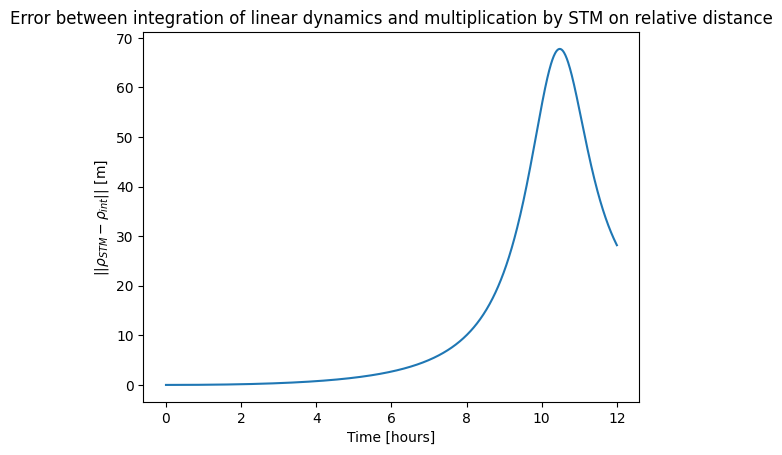

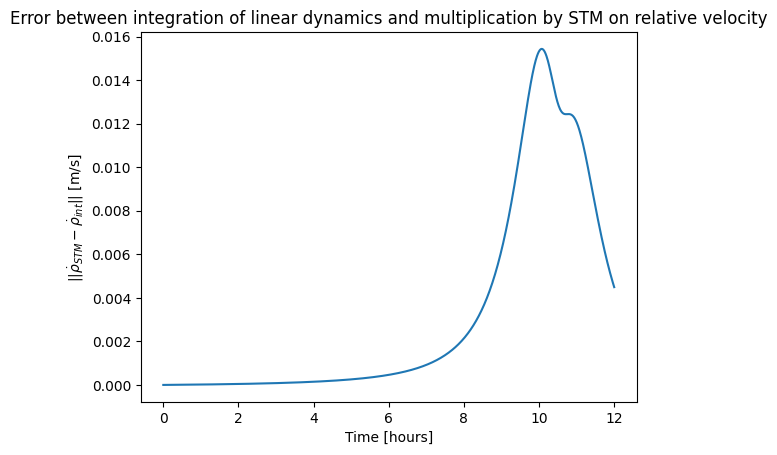

In [1543]:
chaser_trajectory_stm = np.zeros_like(y_orbit[:,:6])
chaser_trajectory_stm[0] = (np.asarray(initial_conditions_chaser_LVLH)).reshape(6)
# chaser_trajectory_stm[0] = (np.asarray(initial_conditions_murakami_LVLH[6:12])).reshape(6)
timing_exp = np.zeros_like(y_orbit[:,0])
timing_approx = np.zeros_like(y_orbit[:,0])
norm_diff_matrix = np.zeros_like(y_orbit[:,0])
for i in range(1,y_orbit.shape[0]):
    delta_t = t_simulation[i]-t_simulation[i-1] # jouer sur les indices MAIS EN FIXANT LES CONDITIONS INITIALES
    start = time.perf_counter()
    phi = sc.linalg.expm(delta_t*matrix_dynamics(y_orbit[i,:],t_simulation[i],mu)) # jouer sur les indices
    end = time.perf_counter()
    timing_exp[i] = end-start
    start2 = time.perf_counter()
    phi2 = get_phi(delta_t,matrix_dynamics(y_orbit[i,:],t_simulation[i],mu),p=5) # similar with get_phi and sc.linalg.expm
    end2 = time.perf_counter()
    timing_approx[i] = end2 - start2
    norm_diff_matrix[i] = np.trace((phi-phi2) @ ((phi-phi2).T)) # this is the norm squared but will work
    chaser_trajectory_stm[i] = (phi @ chaser_trajectory_stm[i-1].reshape((6,1))).reshape(6)
    # chaser_trajectory_stm[i] = (phi2 @ chaser_trajectory_stm[i-1].reshape((6,1))).reshape(6)

error_stm_lin_dist = np.zeros(y_orbit.shape[0])
error_stm_lin_vel = np.zeros(y_orbit.shape[0])
for i in range(y_orbit.shape[0]):
    error = la.norm(chaser_trajectory_stm[i,:3] - y_orbit[i,6:9])
    error_stm_lin_dist[i] = error
    error_vel = la.norm(chaser_trajectory_stm[i,3:6] - y_orbit[i,9:12])
    error_stm_lin_vel[i] = error_vel
    
plt.plot(t_simulation*TU/3600,error_stm_lin_dist*r12*1e3)
plt.xlabel('Time [hours]')
plt.ylabel(r"||$\rho_{STM} - \rho_{int}$|| [m]")
plt.title('Error between integration of linear dynamics and multiplication by STM on relative distance')
plt.show()

plt.plot(t_simulation*TU/3600,error_stm_lin_vel*r12*1e3/TU)
plt.xlabel('Time [hours]')
plt.ylabel(r"||$\dot{\rho}_{STM} - \dot{\rho}_{int}$|| [m/s]")
plt.title('Error between integration of linear dynamics and multiplication by STM on relative velocity')
plt.show()

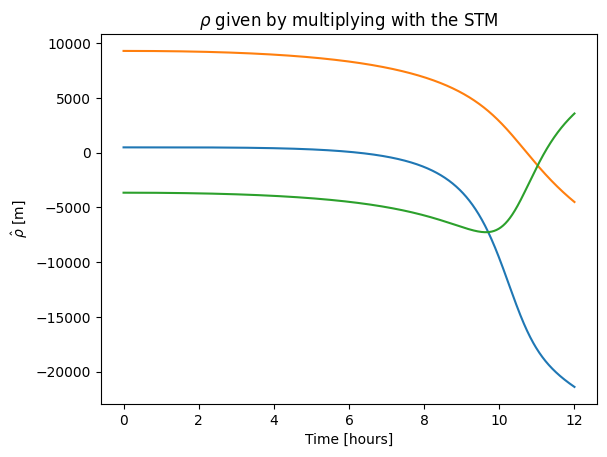

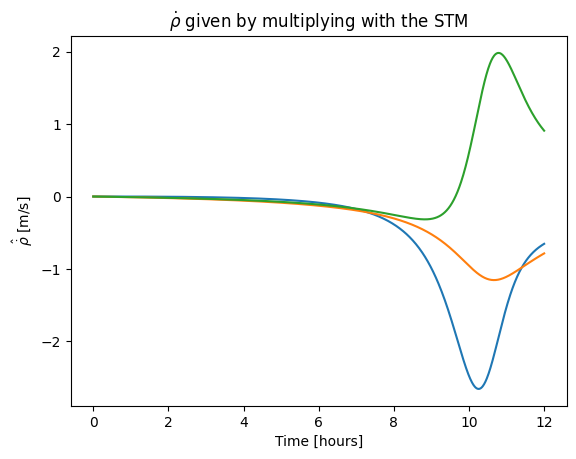

In [1544]:
plt.plot(t_simulation*TU/3600,chaser_trajectory_stm[:,:3]*r12*1e3)
plt.xlabel('Time [hours]')
plt.ylabel(r"$\hat{\rho}$ [m]")
plt.title(r'$\rho$ given by multiplying with the STM')
plt.show()

plt.plot(t_simulation*TU/3600,chaser_trajectory_stm[:,3:6]*r12*1e3/TU)
plt.xlabel('Time [hours]')
plt.ylabel(r"$\hat{\dot{\rho}}$ [m/s]")
plt.title(r'$\dot{\rho}$ given by multiplying with the STM')
plt.show()

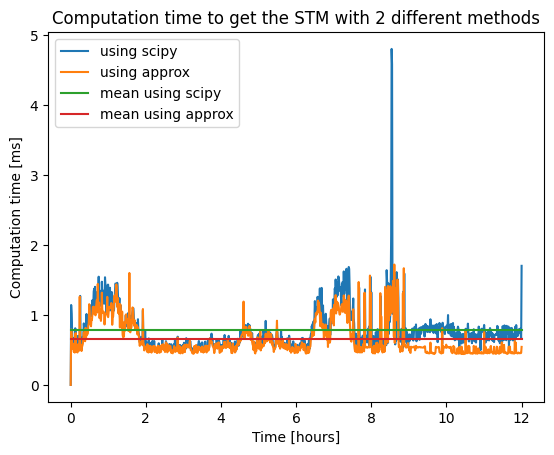

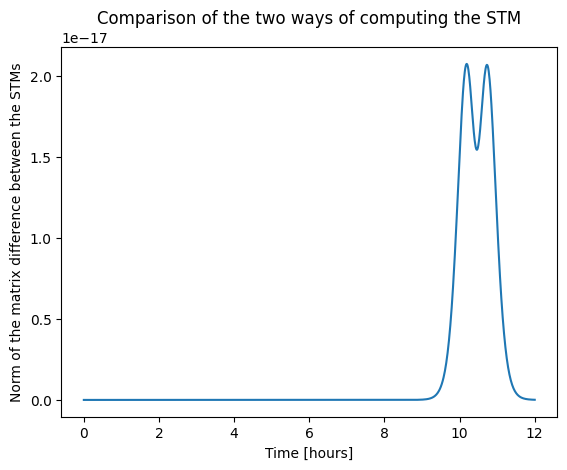

In [1545]:
# print(np.mean(timing_exp),np.average(timing_exp)*np.ones_like(y_orbit[:,0]))

plt.plot(t_simulation*TU/3600,timing_exp*1e3,label='using scipy')
plt.plot(t_simulation*TU/3600,timing_approx*1e3,label='using approx')
plt.plot(t_simulation*TU/3600,np.average(timing_exp)*np.ones_like(y_orbit[:,0])*1e3,label='mean using scipy')
plt.plot(t_simulation*TU/3600,np.average(timing_approx)*np.ones_like(y_orbit[:,0])*1e3,label='mean using approx')
plt.xlabel('Time [hours]')
plt.ylabel(r"Computation time [ms]")
plt.title('Computation time to get the STM with 2 different methods')
plt.legend()
plt.show()

plt.plot(t_simulation*TU/3600,norm_diff_matrix)
plt.xlabel('Time [hours]')
plt.ylabel(r"Norm of the matrix difference between the STMs")
plt.title('Comparison of the two ways of computing the STM')
plt.show()

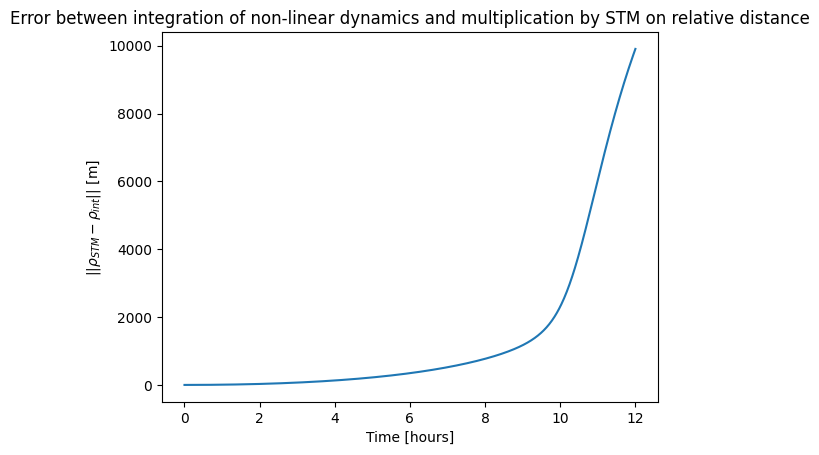

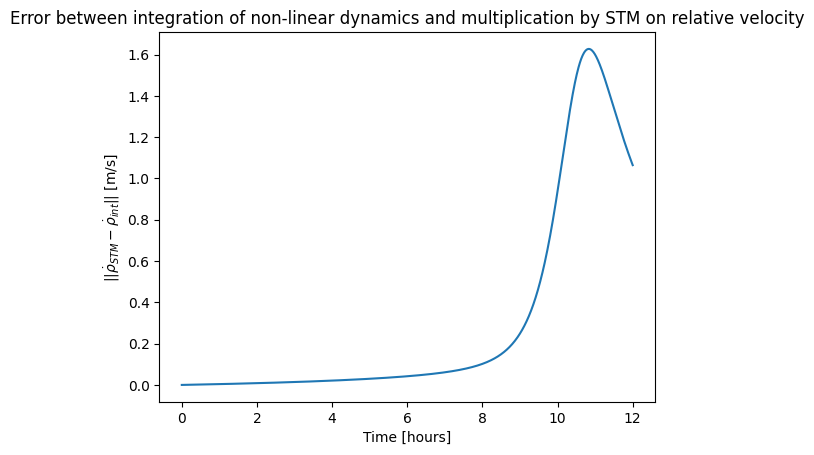

In [1546]:
error_stm_nonlin_dist = np.zeros(y_orbit.shape[0])
error_stm_nonlin_vel = np.zeros(y_orbit.shape[0])
for i in range(y_orbit.shape[0]):
    error = la.norm(chaser_trajectory_stm[i,:3] - rho_LVLH_history_true[i,:3])
    error_stm_nonlin_dist[i] = error
    error_vel = la.norm(chaser_trajectory_stm[i,3:6] - rho_dot_LVLH_history_true[i,:3])
    error_stm_nonlin_vel[i] = error_vel
    
plt.plot(t_simulation*TU/3600,error_stm_nonlin_dist*r12*1e3)
plt.xlabel('Time [hours]')
plt.ylabel(r"||$\rho_{STM} - \rho_{int}$|| [m]")
plt.title('Error between integration of non-linear dynamics and multiplication by STM on relative distance')
plt.show()

plt.plot(t_simulation*TU/3600,error_stm_nonlin_vel*r12*1e3/TU)
plt.xlabel('Time [hours]')
plt.ylabel(r"||$\dot{\rho}_{STM} - \dot{\rho}_{int}$|| [m/s]")
plt.title('Error between integration of non-linear dynamics and multiplication by STM on relative velocity')
plt.show()

In [1547]:
# Saving the target and chaser spacecrafts' trajectories in a csv file
file = open("target_chaser_traj.csv","w")
writer = csv.writer(file)
for l in range(len(y_orbit[:,0])):
    if l>0:
        # To save the target trajectory and the propagation of the chaser's trajectory with NON-LINEAR dynamics
        data = np.concatenate(([t_simulation[l]],y_orbit[l,:6],rho_LVLH_history_true[l,:],rho_dot_LVLH_history_true[l,:]))
    elif l == 0:
        # To save the target trajectory and the propagation of the chaser's trajectory with LINEAR dynamics
        data = np.concatenate(([t_simulation[l]],y_orbit[l,:6],rho_LVLH_history_true[l,:],rho_dot_LVLH_history_true[l,:]))
    writer.writerow(data)
file.close()

In [1548]:
# print(rho_LVLH_history_true[0,:],rho_x0_LVLH,rho_y0_LVLH,rho_z0_LVLH)
# print(rho_LVLH_history_true[0,:],initial_conditions_chaser_LVLH[:3])
# print(rho_LVLH_history_true[0,:],initial_conditions_murakami_LVLH[6:9])

# print(rho_dot_LVLH_history_true[0,:],rho_vx0_LVLH,rho_vy0_LVLH,rho_vz0_LVLH)
# print(rho_dot_LVLH_history_true[0,:],initial_conditions_chaser_LVLH[3:])
# print(rho_dot_LVLH_history_true[0,:],initial_conditions_murakami_LVLH[9:12])

Just checking again that linear and non-linear (when integrated with odeint) are close enough

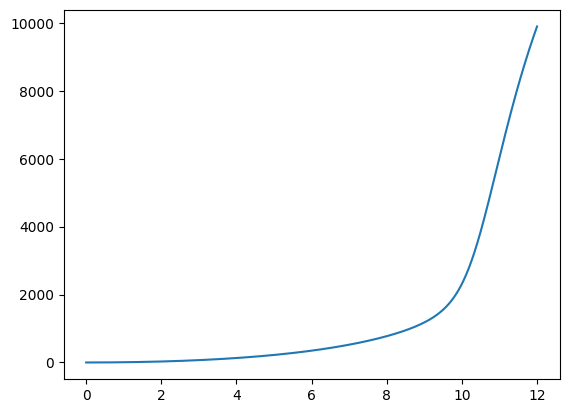

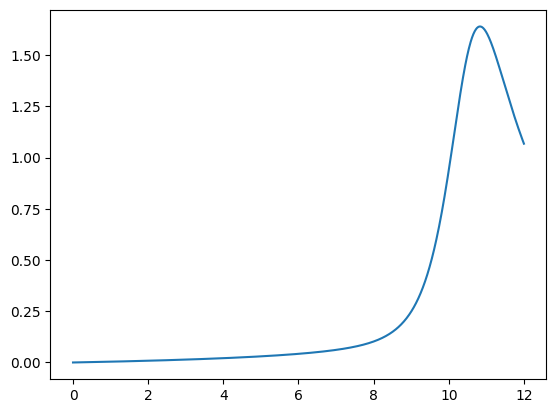

In [1549]:
error_lin_nonlin = np.zeros(y_orbit.shape[0])
error_lin_nonlin_vel = np.zeros(y_orbit.shape[0])
for i in range(y_orbit.shape[0]):
    error_lin_nonlin[i] = la.norm(y_orbit[i,6:9] - rho_LVLH_history_true[i,:])
    error_lin_nonlin_vel[i] = la.norm(y_orbit[i,9:12] - rho_dot_LVLH_history_true[i,:])

plt.plot(t_simulation*TU/3600,error_lin_nonlin*r12*1e3)
plt.show()

plt.plot(t_simulation*TU/3600,error_lin_nonlin_vel*r12*1e3/TU)
plt.show()